In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os

In [61]:
data = pd.read_csv('train.csv')
data

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,Green-House,Find Home,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.993000,0.824000,0.0984,0.1770,171.587,193450.0,3,6
17992,Micatone,All Gone,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,257067.0,4,2
17993,Smash Hit Combo,Peine perdue,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,216222.0,4,8
17994,Beherit,Salomon's Gate,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,219693.0,4,8


In [62]:
# Размерность данных
print(f"Размер данных: {data.shape}")

# Типы данных
print("\nТипы данных в столбцах:")
print(data.dtypes)

# Пропуски
print("\nКоличество пропущенных значений:")
print(data.isnull().sum())

# Основные статистики
print("\nОсновные статистики числовых столбцов:")
print(data.describe())

df = data

Размер данных: (17996, 17)

Типы данных в столбцах:
Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object

Количество пропущенных значений:
Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in 

Первым делом - мы не удаляем выбросы в громкости по простой причине - громкость зависит от жанра, что очень легко проследить. Все жанры кроме 7-ого относительно громкие, выбросы также везде разные. Так например у 0, 3 и 4-ого класса они минимальны.

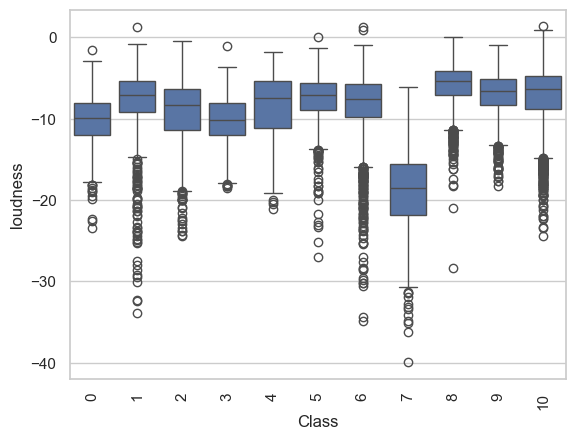

In [ ]:
sns.boxplot(x='Class', y='loudness', data=df)
plt.xticks(rotation=90)
plt.show()

Считаем процентиили, после чего высчитываем середину всех данных.

In [ ]:

Q1 = df['loudness'].quantile(0.25)
Q3 = df['loudness'].quantile(0.75)

IQR = Q3 - Q1

# 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df[(df['loudness'] < lower_bound) | (df['loudness'] > upper_bound)]
print(len(outliers))
print(outliers)

818
             Artist Name                 Track Name  Popularity  danceability  \
34     The Ayoub Sisters             Mother's Pride        16.0         0.297   
48           Victor Manu                   Raphaela        47.0         0.494   
90         Elena Falwell            Elegi For Cello        41.0         0.167   
113             Pathiena      The Deepest Of Sorrow        40.0         0.645   
129     Townes Van Zandt      Waitin' Around To Die        52.0         0.551   
...                  ...                        ...         ...           ...   
17935               Ravi                   The Jali        28.0         0.428   
17945      Eddie Higgins  Falling In Love With Love        34.0         0.567   
17951             Adeben                  die Zeder        45.0         0.552   
17990  Henrik Lindstrand               Hallonlandet        26.0         0.468   
17991        Green-House                  Find Home        35.0         0.166   

       energy  key  lou